# Assignment 2: Topic modeling
Authors: Noa Onoszko and Gustav Molander

In this assignment we perform Latent Dirichlet Allocation (LDA) for topic modeling. LDA does two things: classifying documents into topics and generates words from those topics. We will look at the latter application so the results will be list of the most common words for each topic.

For inference on the parameters in the LDA model, $\theta_d$ and $\phi_k$, we will use random walk Markov Chain Monte Carlo and specifically Gibbs sampling. 

We compare results obtained from doing unigram LDA with standard Gibbs sampling, unigram LDA with collapsed Gibbs sampling and bigram LDA with collapsed Gibbs sampling. The latter model uses contextual knowledge instead of relying on a bag-of-words representation of the corpus.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip 'drive/My Drive/NLP/Assignment_1/a1_data.zip'

Mounted at /content/drive
Archive:  drive/My Drive/NLP/Assignment_1/a1_data.zip
   creating: a1_data/
  inflating: __MACOSX/._a1_data      
  inflating: a1_data/books.txt       
  inflating: __MACOSX/a1_data/._books.txt  
  inflating: a1_data/wikipedia.txt   
  inflating: __MACOSX/a1_data/._wikipedia.txt  
  inflating: a1_data/europarl.txt    
  inflating: __MACOSX/a1_data/._europarl.txt  


## Data preparation

The corpus we are using is comprised of book reviews on Amazon. This means that there could be a lot of misspelled words, and even unintelligible ones. Furthermore, a lot of words do not carry much meaning and can not be assigned to a topic. Therefore our preprocessing is going to consist of the following:


*   Removing all stopwords, such as the, is, at, which
*   Removing special caracters such as ".", ",", ":", ";", """"
*   Lemmatization of the corpus to combine the counts of different inflections

We create a subcorpus consisting of 1400 reviews from the book review corpus, which contains ≈100 000 tokens after preprocessing. The vocabulary consists of a little over 15000 tokens. Here, tokens refers to entities separated by space which is for the most part words, but can also be names, numbers and strange strings like "n't". Further preprocessing could be beneficial.

In addition to preprocessing, we prepare for the analysis by tokenzing the corpus and define hyperparameters. We also create a vocabulary of all words and encode them as integers.

In [65]:
import numpy as np
import spacy
import nltk
from nltk.stem.porter import *
import string
from tqdm.notebook import tqdm
from tqdm.auto import trange

def generate_corpus(D):
  corpus = []
  with open("a1_data/books.txt", encoding="ISO-8859-1") as f:
      corpus = [line.lower().split() for l, line in enumerate(f) if l < D]
  return corpus

# Generate D documents
D = 1400 # 1400 number of documents
corpus = generate_corpus(D)

# Number of words before preprocessing
vocab = list(set(word for doc in corpus for word in doc))
V = len(vocab) # vocab size
print("Number of tokens and unique tokens before preprocessing: ", sum(len(line) for line in corpus), ", ", V, sep="")

# Preprocess: Remove stopwords and punctuation
stemmer = PorterStemmer()
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words
# stemmer.stem(sp(word)[0].lemma_) for stemming
for d, doc in enumerate(tqdm(corpus)):
  corpus[d] = [sp(word)[0].lemma_ for word in doc if not word in all_stopwords and not word in string.punctuation]


# Number of words before preprocessing
vocab = list(set(word for doc in corpus for word in doc))
V = len(vocab) # vocab size
vocab_dict = dict(zip(vocab, range(V)))
print("Number of tokens and unique tokens before preprocessing: ", sum(len(line) for line in corpus), ", ", V, sep="")

Number of tokens and unique tokens before preprocessing: 250602, 19987



Number of tokens and unique tokens before preprocessing: 100472, 15079


## Standard Gibbs sampling for unigram LDA
The first approach is to use regular Gibbs sampling, which essentially works in a few steps:


1.   Generate $\theta_d$ ~ Dir($\alpha$, ..., $\alpha$) and $\phi_k$ ~ Dir($\beta$, ..., $\beta$)
2.   Choose topic $k$ for word $j$ in document $d$ with probability proportional to $\theta_d(k)  \phi_k(v)$ where $v$ is the unique word corresponding to the j:th word in document $d$.
3. Use the count of words with topic $k$ per document and count of words with topic $k$ all documents to update $\theta_d$ and $\phi_k$
4. Repeat from 2 200 times

This will generate an approximate sample from the posterior distributions of $\theta_d$ and $\phi_k$ that we will use to visualize the topics.

In [18]:
# Gibbs initialization of distribution
from tqdm import tqdm
from tqdm.auto import trange
from time import sleep

# Hyperparameters
alpha = 0.01
beta = alpha
K = 50
n_iter = 200


# Initialize parameters
theta = np.zeros((D, K))
phi = np.zeros((K, V))
for d in range(D):
  theta[d] = np.random.dirichlet(K*[alpha]) # 1/K * np.ones(K), uniform distribution, was tried without success
for k in range(K):
  phi[k, :] = np.random.dirichlet(V*[beta]) # 1/V * np.ones(V), uniform distribution, was tried without success

thetas = np.zeros((n_iter, D, K))
phis = np.zeros((n_iter, K, V))
thetas[0] = theta
phis[0] = phi

# Gibbs iterations
for iter in trange(n_iter):
  # Generate topics
  Z_dj = D*[[]]
  for d in range(D):
    Z_dj[d] = len(corpus[d]) * [0]
    for j in range(len(corpus[d])):
      p = [theta[d,k]*phi[k,j] for k in range(K)]
      p = p/sum(p)
      Z_dj[d][j] = np.random.choice(range(K), p=p) # np.argmax(p), argmax of the multinomial distribution, was tried without success
  
  # Update distributions
  n_d = np.zeros((D, K))
  m_k = np.zeros((K, V))
  for d in range(D):
    for j in range(len(corpus[d])):
      n_d[d, Z_dj[d][j]] += 1
      m_k[Z_dj[d][j], vocab_dict[corpus[d][j]]] += 1
  for d in range(D):
    theta[d] = np.random.dirichlet(K*[alpha] + n_d[d])
  for k in range(K):
    phi[k] = np.random.dirichlet(V*[beta] + m_k[k])
    
  # Save parameters
  thetas[iter] = theta
  phis[iter] = phi

First, let us look at some trace plots from the Gibbs sampling. We see that the parameter values generally concentrated and polarized - either close to 0 or close to 1. This means that the model is very certain which topic each word belongs to and which topic each document belongs to.

The trace plots show values of $\theta_0(0)$, $\theta_0(1)$, $\phi_0(0)$, $\phi_0(1)$ for all iterations.

In the trace plot for $\theta_0(0)$ we see a burn_in of approximately 30 iterations whereas the other parameters seem to stay close to the initial values.

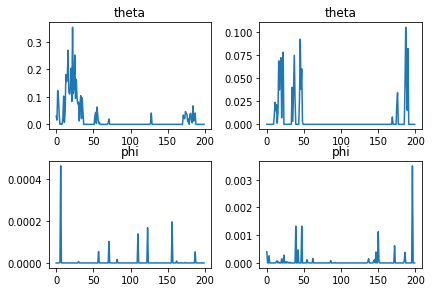

In [24]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2)
fig.tight_layout()
i = 0
axs[0,0].plot(range(n_iter), thetas[:,i,0], label="theta_{0,0}")
axs[0,1].plot(range(n_iter), thetas[:,i,1], label="theta")
axs[1,0].plot(range(n_iter), phis[:,i,0], label="phi")
axs[1,1].plot(range(n_iter), phis[:,i,1], label="phi")
axs[0,0].set_title("theta")
axs[0,1].set_title("theta")
axs[1,0].set_title("phi")
axs[1,1].set_title("phi")
plt.show()

We can also look at the histogram of for example $\phi_2(0)$. The model is fairly certain that $\phi_2(0)$ is close to 0.

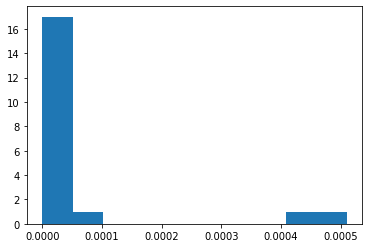

In [28]:
i = 2
plt.hist(phis[:20,i,0])
plt.show()

To investigate the topics for words, we use two different approaches.

### Topics calculated by absolute frequency
First, we look at the words in each category $k$ with highest $\phi_k$, using the value of $\phi_k$ from the last iteration. We get very similar words in all categories and we fail to distinguish any meaningful topics. This is reasonable, since we have not adjusted for total word frequency and all reviews are about books.

Below are the first five topics.  
['book', 'real', 'good', 'turn', 'couplke', 'story', 'like', 'french', 'great', 'process']  
['book', 'feel', 'find', 'good', 'get', 'read', 'model', 'event', 'people', 'life']  
['work', 'want', 'hope', 'possible', 'jefferson', 'crime', 'easily', 'detective', 'time', 'context']  
['book', 'good', 'read', 'story', 'find', 'real', 'clear', 'language', 'accurate', 'life']  
['book', 'like', 'read', 'good', 'year', 'love', 'find', 'life', 'go', 'think']

In [30]:
def print_top_words_by_phi(phi):
  top_words = 10
  for k in range(K):
    ind = np.argpartition(phi[k], -top_words)[-top_words:]
    ind = ind[np.argsort(phi[k, ind])]
    global vocab
    print([vocab[i] for i in np.flip(ind)])
print_top_words_by_phi(phi)

['book', 'real', 'good', 'turn', 'couplke', 'story', 'like', 'french', 'great', 'process']
['book', 'feel', 'find', 'good', 'get', 'read', 'model', 'event', 'people', 'life']
['work', 'want', 'hope', 'possible', 'jefferson', 'crime', 'easily', 'detective', 'time', 'context']
['book', 'good', 'read', 'story', 'find', 'real', 'clear', 'language', 'accurate', 'life']
['book', 'like', 'read', 'good', 'year', 'love', 'find', 'life', 'go', 'think']
['book', 'history', 'time', 'find', 'like', 'man', 'read', 'certainly', 'story', 'year']
['book', 'read', 'great', 'probably', 'good', 'finshed', 'love', 'begin', 'boil', 'x']
['book', 'body', 'beast', 'new', 'young', 'buddha', 'read', 'reader', 'tell', 'knows']
['book', 'write', 'large', 'love', 'tokyo', 'think', 'rap', 'daughter', 'start', 'find']
['book', 'read', 'go', 'like', 'people', 'give', 'serve', 'understand', 'good', 'touch']
['book', 'read', 'good', 'write', 'story', 'thing', 'find', 'page', 'like', 'love']
['book', 'give', 'family', '

### Topics calculated by relative frequency
Next, we sample 100 000 words in each topic using $\phi_k$ from the last iteration of the Gibbs sampling. This should yield similar results as when looking at $\phi_k$ directly since the sample size is large, more than 6 times larger than the vocabulary size. To get the most typical words for each document, we divide the document frequency by the total word frequency, after filtering for the 1000 most common words in the corpus. The filtering excludes words that are misspelled and otherwise very unusual. Removing rare words is good for at least two reasons. First, we will get rid of words that appear very few times and coincidentally have the same topic, which will give them the maximal relative frequency 1. Secondly, and somewhat related, the frequence of rare words is not statistically significant.

Looking at the 10 most common words in each sample, we get different words in each topic, but the words do not seem related.

In [31]:
from collections import *
def print_top_words_by_sampling(phi):
  word_counters = []
  total_word_counter = Counter()
  generated_words = []
  sample_size = 100000
  global vocab
  for k in range(K):
    words = np.random.choice(vocab, sample_size, p=phi[k])
    generated_words.extend(words)
    word_counter = Counter()
    for word in words:
      word_counter[word] += 1
      total_word_counter[word] += 1
    word_counters.append(word_counter)
    
  new_word_counters = []
  most_common_counter = total_word_counter.most_common(1000)
  for k in range(K):
    most_common_words = [item[0] for item in most_common_counter]
    new_word_counters.append(Counter({word: word_counters[k][word] for word in most_common_words}))


  word_counters = new_word_counters
  for k in range(K):
    word_counter = word_counters[k]
    for w, word_and_count in enumerate(word_counter.most_common()):
      word = word_and_count[0]
      word_counter[word] = word_counter[word] / total_word_counter[word]

  for k in range(K):
    #print("---------- k =", k, "----------")
    print([item[0] for item in word_counters[k].most_common(10)])

print_top_words_by_sampling(phi)

['special', 'french', 'official', 'highet', 'trip', 'college', 'brief', 'wake', 'travel', 'publish']
['model', 'destroy', 'reward', 'dictionary', 'romance', 'kill', 'king', 'sad', 'useful', 'twist']
['detective', 'jefferson', 'context', 'fat', 'weak', 'primary', 'crime', 'psychological', 'david', 'improve']
['accurate', 'lengthy', 'restaurant', 'hire', 'usual', 'island', 'content', 'master', 'possibly', 'language']
['collection', 'desire', 'focus', 'eat', 'fantasy', 'half', 'surprised', 'revelation', 'disease', 'adventure']
['cool', 'fantasy', 'tool', 'certainly', 'local', 'soul', 'letter', 'structure', 'extraordinary', 'sorry']
['x', 'management', 'marriage', 'bill', 'range', 'related', 'appropriate', 'judge', 'trouble', 'capture']
['beast', 'buddha', 'revelation', 'secretary', 'un', 'global', 'margaret', 'body', 'knows', '10']
['tokyo', 'rap', 'joke', 'myth', 'dad', 'mistake', 'shakespeare', 't', 'comprehensive', 'sleep']
['careful', 'absolute', 'sarney', 'commitment', 'touch', 'perf

## Collapsed Gibbs sampling for unigram LDA
Collapsed Gibbs is an alternative to standard Gibbs sampling that directly calculates the probability that a word has a certain topic from counts, without calculating $\theta_d$ and $\phi_k$ in every iteration. This makes it approximately twice as our previous implementation.

As before, we can not see any patterns in the topics calculated from absolute frequencies of words. However, using relative frequencies and filtering out rare words we get six good patterns that are shown in the table below.

Success | Spirituality | Education | Evolution | Math | War 
--- | --- | --- | --- | --- | ---
repeat | `soul` | highet | `scientific` | `fourier` | `soviet` 
cross | `mystical` | jenna | target | `transform` | `soldier` 
`poor` | meal | tie | `darwin` | `discrete` | `german`
`successful` | `mankind` | `expert` | william | `system` | thoroughly
`rich` | service | `learning` | ready | `analysis` | `target`
`praise` | afraid | `teacher` | forward | song | `red`
disappointed | coffee | `teaching` | `sex` | exactly | `battle` 
`property` | charge | law | `evolution` | table | model
`success` | `spiritual` | etc | escape | `property` | darwin
`famous` | walk | middle | hell | sleep | addition

In [11]:
# Gibbs initialization of distribution
from tqdm import tqdm
from tqdm.auto import trange
from time import sleep

# Hyperparameters and fixed parameters
alpha = 0.01
beta = alpha
K = 50
n_iter = 200

# Initialize parameters
theta = np.zeros((D, K))
phi = np.zeros((K, V))
for d in range(D):
  theta[d] = np.random.dirichlet(K*[alpha])
for k in range(K):
  phi[k, :] = np.random.dirichlet(V*[beta])

# Initialize topics and counts
Z_dj = D*[[]]
n_d = np.zeros((D, K))
m_k = np.zeros((K, V))
m_all = np.zeros(K)
for d in trange(D):
  Z_dj[d] = len(corpus[d]) * [0]
  for j in range(len(corpus[d])):
    p = [theta[d,k]*phi[k,j] for k in range(K)]
    p = p/sum(p)
    Z_dj[d][j] = np.random.choice(range(K), p=p)
    n_d[d, Z_dj[d][j]] += 1
    m_k[Z_dj[d][j], vocab_dict[corpus[d][j]]] += 1
m_all = np.sum(m_k, axis=1)

# Gibbs iterations
for iter in trange(n_iter):
  prob_k = np.zeros(K)
  for d in range(D):
    for j in range(len(corpus[d])):
      topic = Z_dj[d][j]
      
      # Decrement counters
      n_d[d, topic] -= 1
      m_k[topic, vocab_dict[corpus[d][j]]] -= 1
      m_all[topic] -= 1

      # Update Z
      prob_k = (alpha + n_d[d,:])*(beta + vocab_dict[corpus[d][j]])/(V*beta+m_all)
      prob_k = prob_k / np.sum(prob_k)
      topic = np.random.choice(range(K), p = prob_k)
      Z_dj[d][j] = topic

      # Increment counters
      n_d[d, topic] += 1
      m_k[topic, vocab_dict[corpus[d][j]]] += 1
      m_all[topic] += 1
  
  

for d in range(D):
  theta[d] = np.random.dirichlet(K*[alpha] + n_d[d])
for k in range(K):
  phi[k] = np.random.dirichlet(V*[beta] + m_k[k])


### Top words in each topic calculated by absolute frequency

In [12]:
print_top_words_by_phi(phi)

['book', 'find', 'history', 'fact', 'biography', 'provide', 'story', 'know', 'good', 'reading']
['book', 'prospero', 'life', 'novel', 'time', 'god', 'love', 'miranda', 'like', 'reading']
['book', 'end', 'know', 'author', 'great', 'word', 'get', 'think', 'good', 'story']
['book', 'character', 'way', 'time', 'new', 'find', 'starling', 'good', 'great', 'child']
['book', 'read', 'find', 'world', 'like', 'think', 'write', 'story', 'great', 'good']
['book', 'good', 'asher', 'love', 'read', 'great', 'hilda', 'find', 'reading', 'like']
['book', 'good', 'time', 'read', 'make', 'come', 'course', 'look', 'work', 'need']
['book', 'author', 'work', 'good', 'story', 'see', 'great', 'subject', 'teritorie', 'father']
['book', 'life', 'read', 'great', 'good', 'recommend', 'novel', 'start', 'give', 'time']
['book', 'good', 'read', 'man', 'year', 'dog', 'write', 'time', 'come', 'go']
['book', 'read', 'chapter', 'good', 'author', 'find', 'history', 'henry', 'story', 'murder']
['book', 'read', 'world', 'li

### Top words in each topic calculated by relative frequency

In [15]:
print_top_words_by_sampling(phi)

---------- k = 0 ----------
['oil', 'biography', 'guralnick', 'sam', 'feeling', 'advantage', 'honest', 'promote', 'discover', 'novice']
---------- k = 1 ----------
['prospero', 'king', 'condition', 'god', 'fat', 'ship', 's', 'express', 'break', 'computer']
---------- k = 2 ----------
['available', 'religion', 'christianity', 'constantly', 'biography', 'novice', 'north', 'outcome', 'ultimately', 'weave']
---------- k = 3 ----------
['instruction', 'africa', '20th', 'french', 'homeless', 'increase', '9', 'intelligence', 'dynamic', 'machine']
---------- k = 4 ----------
['lemon', 'west', 'fresh', 'cite', 'fascinating', 'conclude', 'ethical', 'effective', 'recent', 'treat']
---------- k = 5 ----------
['asher', 'afraid', 'hint', 'manager', 'paint', 'tension', '20th', 'killer', 'ice', 'suppose']
---------- k = 6 ----------
['lemon', 'appropriate', 'blue', 'average', 'poem', 'effect', 'music', 'control', 'outcome', 'gift']
---------- k = 7 ----------
['hearing', 'un', 'applied', 'anti', 'arg

## Collapsed Gibbs sampling for bigram LDA
Here we are using an algorithm presented in the paper [Topic modeling: beyond bag-of-words. ICML (2006) 977-984](http://dirichlet.net/pdf/wallach06topic.pdf). We are specifically implementing the E-step of the EM-algorithm in subsection 4.1. The algorithm yields a sample of $Z_{dj}$. Unlike before, we consider not only counts of words in topics but also bigrams.

We use the hyperparameters $\alpha = \beta = 0.01$, with $K=5$ and $K=10$. Collapsed Gibbs sampling is used for this algorithm. To look at topics, we utilize $Z_{dj}$ and calculate absolute and relative frequencies of words for each topic.

For $K=5$, three out of five topics are good. The results are shown below.

Math | Nonsense | WW2 | Nonsense | Nature
--- | --- | --- | --- | ---
`fourier`   | `norris`  | `soviet`  | p         | prospero
`transform` | machine | `army`    | `tree`      | `snow`
`signal`    | erica   | sam     | `garden` | `fish`
`discrete`  | jason   | horse   | medium   | `field`
`mathematics` | oil   | core    | talent   |  `boat`
organize  | intelligence | laugh | jenna | `plant`
indian    | [        | official | smith | christian
humanity  | cat     | `german`   | washington | soul
s         | fail    | document | wish | strength
highet    | `film`    | critical | beginner | rich

For $K=10$, we only get two good topics. Interestingly, the second topic could be either WW2 or intelligence.
Math | WW2 or intelligence 
--- | --- 
`fourier`   | *machine*
`transform` | `army`
`discrete`  | `soviet`   
`signal`    | *intelligence*  
horse | *computer*   
[  | energy 
soul    | `german`        
`system`  | contemporary     
un         | potential    
french    | *brain*    



In [60]:
# Gibbs initialization of distribution
  # {Nwt|wt−1,k}−t  = number of bigrams in the whole corpus where the latter word has topic k,        if the particular word occurence w_t is ignored
  # {Nk|dt}−t       = number of words in the current document with topic k,                           if the particular word occurence w_t is ignored
  # {Nwt−1,k}−t     = number of words in the whole corpus succeeding w_t-1 that has topic k,          if the particular word occurence w_t is ignored
from tqdm import tqdm
from tqdm.auto import trange
from time import sleep

def perform_gibbs_bigram(K):
  # Hyperparameters and fixed parameters
  alpha = 0.01
  beta = alpha
  n_iter = 200

  # Initialize Z_dj
  Z_dj = D*[[]]
  for d in trange(D):
    Z_dj[d] = len(corpus[d]) * [0]
    for j in range(len(corpus[d])):
      Z_dj[d] = np.random.choice(range(K), size = len(corpus[d]))

  # Initialize counters
  N_bigram_k = dict()
  N_succeeding_k = dict()
  N_dk = np.zeros((D, K))
  for d in range(D):
    N_dk[d, Z_dj[d][0]] += 1
    for j in range(len(corpus[d]) - 1):
      unique_word1 = vocab_dict[corpus[d][j]]
      unique_word2 = vocab_dict[corpus[d][j + 1]]
      topic = Z_dj[d][j+1]
      
      # N_bigram_k
      if not unique_word2 in N_bigram_k:  # if dict for succeeding word doesn't exist, create it
          N_bigram_k[unique_word2] = dict()
      if (
          not unique_word1 in N_bigram_k[unique_word2]
      ):  # if dict for preceding word doesn't exist, create it and put empty array in it
          counts_k = np.zeros(K)
          N_bigram_k[unique_word2][unique_word1] = counts_k
      N_bigram_k[unique_word2][unique_word1][topic] += 1

      # N_succeeding_k
      if not unique_word1 in N_succeeding_k:
        counts_k = np.zeros(K)
        N_succeeding_k[unique_word1] = counts_k
      N_succeeding_k[unique_word1][topic] += 1

      # N_dk
      N_dk[d, topic] += 1

  # Gibbs iterations
  for iter in trange(n_iter):
    prob_k = np.zeros(K)
    for d in range(D):
      for j in range(len(corpus[d]) - 1):
        unique_word1 = vocab_dict[corpus[d][j]]
        unique_word2 = vocab_dict[corpus[d][j + 1]]
        topic = Z_dj[d][j+1]
        
        # Decrement counters
        N_bigram_k[unique_word2][unique_word1][topic] -= 1
        N_succeeding_k[unique_word1][topic] -= 1
        N_dk[d, topic] -= 1

        # Update Z
        prob_k = (N_bigram_k[unique_word2][unique_word1][:] + beta)*(N_dk[d, :] + alpha)/(N_succeeding_k[unique_word1][:] + V * beta)
        prob_k = prob_k / np.sum(prob_k)
        topic = np.random.choice(range(K), p = prob_k)
        Z_dj[d][j+1] = topic

        # Increment counters
        N_bigram_k[unique_word2][unique_word1][topic] += 1
        N_succeeding_k[unique_word1][topic] += 1
        N_dk[d, topic] += 1
  return Z_dj
Z_dj = perform_gibbs_bigram(5)

### Topics for $K=5$ using absolute frequency

In [63]:
K = 5
vk_counts = dict()
total_counts = Counter()
for d in range(D):
    for j in range(len(corpus[d]) - 1): # don't consider the first word of each document since this Z has never been updated
      topic = Z_dj[d][j]
      if not topic in vk_counts:
        vk_counts[topic] = Counter()
      unique_word_actual_word = corpus[d][j + 1]
      vk_counts[topic][unique_word_actual_word] += 1

      # Total counts
      total_counts[unique_word_actual_word] += 1

# Print topics by absolute counts
vk_most_common10 = K*[[]]
for k in range(K):
  vk_most_common10[k] = vk_counts[k].most_common(10)
  print(vk_most_common10[k])

[('book', 570), ('read', 171), ('good', 140), ('story', 115), ('like', 106), ('great', 104), ('life', 99), ('way', 87), ('write', 86), ('time', 86)]
[('book', 752), ('read', 203), ('good', 152), ('time', 135), ('like', 131), ('story', 127), ('life', 121), ('great', 113), ('find', 104), ('love', 98)]
[('book', 912), ('read', 246), ('good', 191), ('like', 169), ('find', 168), ('story', 167), ('time', 158), ('life', 134), ('love', 134), ('work', 124)]
[('book', 312), ('read', 104), ('good', 92), ('time', 72), ('great', 71), ('find', 70), ('like', 62), ('story', 55), ('life', 50), ('work', 49)]
[('book', 409), ('read', 113), ('good', 88), ('like', 84), ('work', 67), ('story', 65), ('time', 63), ('find', 61), ('people', 59), ('world', 57)]


### Topics for $K=5$ using relative frequency

In [64]:
# Rename to enable use of old code
word_counters = vk_counts
total_word_counter = total_counts

new_word_counters = []
most_common_counter = total_counts.most_common(1000)
for k in range(K):
  most_common_words = [item[0] for item in most_common_counter]
  new_word_counters.append(Counter({word: word_counters[k][word] for word in most_common_words}))

word_counters = new_word_counters
for k in range(K):
  word_counter = word_counters[k]
  for w, word_and_count in enumerate(word_counter.most_common()):
    word = word_and_count[0]
    word_counter[word] = word_counter[word] / total_word_counter[word]

for k in range(K):
  #print("---------- k =", k, "----------")
  print([item[0] for item in word_counters[k].most_common(10)])

['jason', 'fish', 'medium', 'highet', '[', 'erica', 'oil', 'global', 'commentary', 'education']
['fourier', 'signal', 'transform', 'discrete', 'fairly', 'academic', 'property', 'cross', 'land', 'cat']
['norris', 'jenna', 'crime', 'element', 'drive', 'familiar', 'everyday', 'waste', 'relate', 'bill']
['prospero', 'machine', 'army', 'journalist', 'german', 'magic', 'letter', 'god', 'myth', 'stage']
['sam', 'p', 'soviet', 'snow', 'argument', 'attitude', 'military', 'smith', 'philosophy', 'flaw']


### Perform Gibbs sampling with $K=10$

In [53]:
Z_dj = perform_gibbs_bigram(10)

### Topics for $K=10$ using absolute frequency

In [57]:
K = 10
vk_counts = dict()
total_counts = Counter()
for d in range(D):
    for j in range(len(corpus[d]) - 1): # don't consider the first word of each document since this Z has never been updated
      topic = Z_dj[d][j]
      if not topic in vk_counts:
        vk_counts[topic] = Counter()
      unique_word_actual_word = corpus[d][j + 1]
      vk_counts[topic][unique_word_actual_word] += 1

      # Total counts
      total_counts[unique_word_actual_word] += 1

# Print topics by absolute counts
vk_most_common10 = K*[[]]
for k in range(K):
  vk_most_common10[k] = vk_counts[k].most_common(10)
  print(vk_most_common10[k])

[('book', 150), ('good', 35), ('read', 32), ('love', 26), ('time', 25), ('find', 23), ('world', 20), ('page', 20), ('way', 18), ('great', 18)]
[('book', 76), ('read', 23), ('good', 22), ('time', 19), ('life', 19), ('great', 16), ('story', 15), ('work', 14), ('reader', 13), ('help', 11)]
[('book', 81), ('read', 25), ('sam', 25), ('great', 19), ('time', 18), ('come', 17), ('good', 17), ('like', 16), ('reader', 15), ('guralnick', 14)]
[('book', 1678), ('read', 498), ('good', 355), ('story', 331), ('like', 308), ('time', 278), ('life', 273), ('find', 256), ('great', 254), ('work', 224)]
[('book', 131), ('good', 31), ('life', 25), ('story', 25), ('write', 24), ('know', 24), ('read', 24), ('time', 24), ('work', 23), ('find', 23)]
[('book', 125), ('good', 52), ('read', 40), ('like', 34), ('time', 30), ('find', 28), ('great', 26), ('think', 25), ('novel', 25), ('work', 24)]
[('book', 225), ('like', 55), ('read', 54), ('time', 50), ('good', 48), ('find', 45), ('work', 43), ('story', 39), ('life

### Topics for $K=10$ using relative frequency

In [58]:
# Rename to enable use of old code
word_counters = vk_counts
total_word_counter = total_counts

new_word_counters = []
most_common_counter = total_counts.most_common(1000)
for k in range(K):
  most_common_words = [item[0] for item in most_common_counter]
  new_word_counters.append(Counter({word: word_counters[k][word] for word in most_common_words}))

word_counters = new_word_counters
for k in range(K):
  word_counter = word_counters[k]
  for w, word_and_count in enumerate(word_counter.most_common()):
    word = word_and_count[0]
    word_counter[word] = word_counter[word] / total_word_counter[word]

for k in range(K):
  #print("---------- k =", k, "----------")
  print([item[0] for item in word_counters[k].most_common(10)])

['tree', 'risk', 'smith', 'organization', 'hurt', 'pattern', 'avoid', 'evolution', 'pain', 'johnson']
['highet', 'argument', 'expert', 'necessary', 'accept', 'document', 'require', 'ms', 'support', 'universe']
['sam', 'biography', 'china', 'team', 'mistake', 'software', 'official', 'position', 'commentary', 'flaw']
['prospero', 'vietnam', 'erica', 'rare', 'meal', 'low', 'boat', 'mother', 'beginner', 'share']
['norris', 'presentation', 'u.s', 'stage', 'essay', 'wilson', 'increase', 'gibbon', 'argue', 'medium']
['machine', 'army', 'soviet', 'intelligence', 'computer', 'energy', 'german', 'contemporary', 'potential', 'brain']
['fourier', 'transform', 'discrete', 'signal', 'horse', '[', 'soul', 'system', 'un', 'french']
['snow', 'plant', 'meaning', 'popular', 'straight', 'security', 'part', 'translation', 'editor', 'choice']
['song', 'oil', 'americans', 'fresh', 'program', 'journalist', 'de', 'cold', 'stupid', 'service']
['jenna', 'global', 'car', 'train', 'recipe', 'natural', 'huge', 'rel

### Discussion
We tried $\alpha=\beta=0.1$ and $\alpha=\beta=0.01$. The latter showed superior results for the collapsed Gibbs sampling. We also found that $K=50$ worked better than $K=10$ for unigram LDA. No combination of parameters made standard Gibbs samppling successful which is strange. Initializing the document-topic and topic-word distributions to the uniform distribution did not help either.

Contrary to the unigram case, fewer topics worked better for bigram LDA.